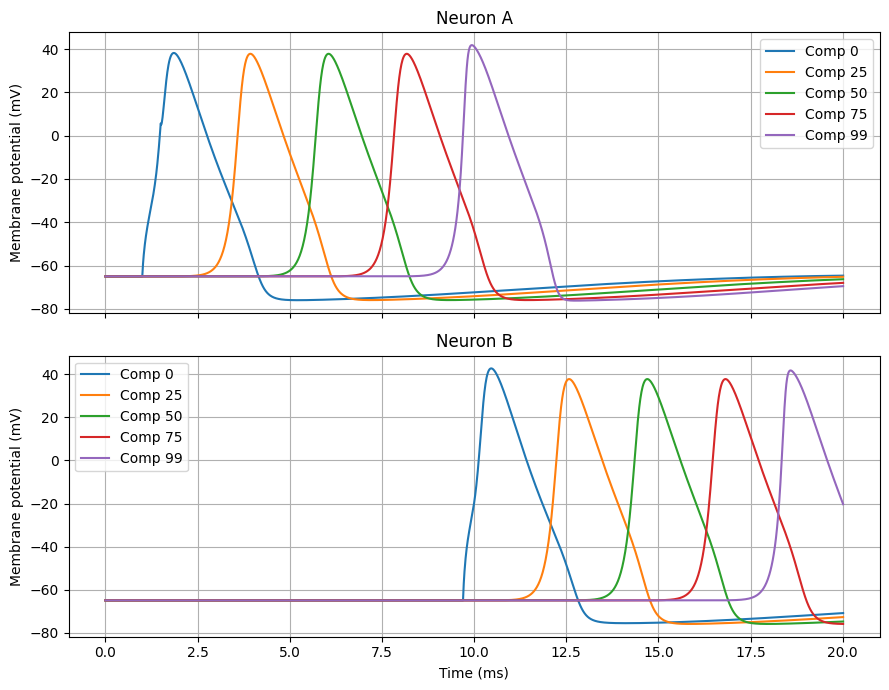

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Hodgkin–Huxley helpers
def alpha_m(V): return 0.1 * (V + 40.0) / (1.0 - np.exp(-0.1 * (V + 40.0)))
def beta_m(V):  return 4.0 * np.exp(-(V + 65.0) / 18.0)
def alpha_h(V): return 0.07 * np.exp(-(V + 65.0) / 20.0)
def beta_h(V):  return 1.0 / (1.0 + np.exp(-0.1 * (V + 35.0)))
def alpha_n(V): return 0.01 * (V + 55.0) / (1.0 - np.exp(-0.1 * (V + 55.0)))
def beta_n(V):  return 0.125 * np.exp(-(V + 65.0) / 80.0)

# Multi‑compartment integrator
def integrate_multicompartment(
    electrode_current_injector,
    num_compartments=100,
    duration=20.0,
    dt=0.01,
    comp_L=0.004, comp_a=1e-4,
    cm=1.0,
    rL=100.0,
    initial_voltages=None,
    gL=0.3,   EL=-54.387,
    gNa=120.0, ENa=50.0,
    gK=36.0,  EK=-77.0):
    if initial_voltages is None:
        initial_voltages = np.full(num_compartments, -65.0)
    surf = 2 * np.pi * comp_a * comp_L
    g_ax = (np.pi * comp_a**2) / (rL * comp_L)
    g_ax_area = (g_ax / surf) * 1000.0

    t_vec = np.arange(0, duration + dt, dt)
    V = np.zeros((len(t_vec), num_compartments))
    m = np.zeros_like(V); h = np.zeros_like(V); n = np.zeros_like(V)
    V[0] = initial_voltages
    for i, v0 in enumerate(initial_voltages):
        m[0,i] = alpha_m(v0)/(alpha_m(v0)+beta_m(v0))
        h[0,i] = alpha_h(v0)/(alpha_h(v0)+beta_h(v0))
        n[0,i] = alpha_n(v0)/(alpha_n(v0)+beta_n(v0))

    a = np.zeros(num_compartments); b = np.zeros_like(a); c = np.zeros_like(a); r = np.zeros_like(a)

    for k in range(len(t_vec)-1):
        v = V[k]; m_k = m[k]; h_k = h[k]; n_k = n[k]; t_ms = t_vec[k]

        # update gating
        m_inf = alpha_m(v)/(alpha_m(v)+beta_m(v)); tau_m = 1/(alpha_m(v)+beta_m(v))
        h_inf = alpha_h(v)/(alpha_h(v)+beta_h(v)); tau_h = 1/(alpha_h(v)+beta_h(v))
        n_inf = alpha_n(v)/(alpha_n(v)+beta_n(v)); tau_n = 1/(alpha_n(v)+beta_n(v))
        m_next = m_inf + (m_k - m_inf) * np.exp(-dt/tau_m)
        h_next = h_inf + (h_k - h_inf) * np.exp(-dt/tau_h)
        n_next = n_inf + (n_k - n_inf) * np.exp(-dt/tau_n)
        m[k+1] = m_next; h[k+1] = h_next; n[k+1] = n_next

        gNa_act = gNa * (m_next**3) * h_next
        gK_act  = gK  * (n_next**4)

        for i in range(num_compartments):
            I_e_nA = electrode_current_injector(i, t_ms)
            I_e = (I_e_nA * 1e-3) / surf

            g_total = gL + gNa_act[i] + gK_act[i]
            gE_total = gL*EL + gNa_act[i]*ENa + gK_act[i]*EK

            g_ax_sum = 0.0; A = 0.0; C = 0.0; rhs_exp = 0.0
            if i>0:
                A = g_ax_area/cm; g_ax_sum += g_ax_area; rhs_exp += A*v[i-1]
            if i<num_compartments-1:
                C = g_ax_area/cm; g_ax_sum += g_ax_area; rhs_exp += C*v[i+1]
            B = -(g_total + g_ax_sum)/cm
            rhs_exp += B*v[i]

            D = (gE_total + I_e)/cm

            a[i] = -A*dt; b[i] = 1.0 - B*dt; c[i] = -C*dt; r[i] = (D + rhs_exp)*dt

        # Thomas algorithm
        N = num_compartments
        cp = np.zeros(N); dp = np.zeros(N); dV = np.zeros(N)
        cp[0] = c[0]/b[0]; dp[0] = r[0]/b[0]
        for i in range(1, N):
            denom = b[i] - a[i]*cp[i-1]
            cp[i] = c[i]/denom if i < N-1 else 0.0
            dp[i] = (r[i] - a[i]*dp[i-1])/denom
        dV[-1] = dp[-1]
        for i in range(N-2, -1, -1):
            dV[i] = dp[i] - cp[i]*dV[i+1]

        V[k+1] = v + dV

    return t_vec, V

# Synapse
class Synapse:
    def __init__(self, tau_s=1.0, g_bar=50.0, P_max=1.0, E_s=0.0):
        self.tau_s = tau_s
        self.g_bar = g_bar
        self.P_max = P_max
        self.E_s = E_s
        self.P = 0.0
    def step(self, spike, dt):
        self.P -= (self.P/self.tau_s)*dt
        if spike:
            self.P += self.P_max*(1-self.P)
        return self.P

# network
dt = 0.01
duration = 20.0
ncomp = 100
# stimulate neuron A at its soma (compartment 0)
def I_inj_A(idx, t):
    return 1.0 if idx == 0 and 1.0 <= t < 1.5 else 0.0

time, V_A = integrate_multicompartment(I_inj_A, num_compartments=ncomp,
                                       duration=duration, dt=dt)

# detect spike arrival at end of A
end_V = V_A[:, -1]
spk_times = [time[i] for i in range(1, len(end_V))
             if end_V[i] >= 0.0 and end_V[i-1] < 0.0]

# drive synapse and pre‑compute current to soma of B
surf = 2 * np.pi * 1e-4 * 0.004
syn = Synapse(tau_s=1.0, g_bar=10.0, E_s=0.0)
I_B_trace = np.zeros_like(time)
for k, t_ms in enumerate(time):
    spike_flag = any(abs(t_ms - st) < 0.5*dt for st in spk_times)
    P = syn.step(spike_flag, dt)
    g_syn = P * syn.g_bar
    I_density = g_syn * (syn.E_s + 54.387)
    I_B_trace[k] = I_density * surf * 1000.0

def I_inj_B(idx, t):
    if idx == 0:
        return I_B_trace[int(round(t/dt))] if t <= duration else 0.0
    return 0.0

time, V_B = integrate_multicompartment(I_inj_B, num_compartments=ncomp,
                                       duration=duration, dt=dt)

# Visualisation
sel = [0, 25, 50, 75, 99] # compartments to plot

fig, axes = plt.subplots(2, 1, figsize=(9, 7), sharex=True)
fig.subplots_adjust(hspace=0.3)
# neuron A
for c in sel:
    axes[0].plot(time, V_A[:, c], label=f'Comp {c}')
axes[0].set_title('Neuron A')
axes[0].set_ylabel('Membrane potential (mV)')
axes[0].grid(); axes[0].legend()

# neuron B
for c in sel:
    axes[1].plot(time, V_B[:, c], label=f'Comp {c}')
axes[1].set_title('Neuron B')
axes[1].set_xlabel('Time (ms)'); axes[1].set_ylabel('Membrane potential (mV)')
axes[1].grid(); axes[1].legend()

fig.tight_layout()

